# Interview presentation: fMRI data Analyst
Shreya Kapoor <br>
M.Sc. Life Science Informatics <br>
Bonn Aachen International Center for Information Technology <br>

## Extraction of most predictive subgraphs from models of human brain connectivity

![title](visualization/Pipeline.png)

Outline
- Preprocessing of DTI data from Human Connectome project (s900 release)
- Extracting Connectivity Matrices from DTI tractography
- Feature selection based on Statistical Analysis
    - Graph solver based feature selection
- Training a Machine Learning classifier


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from processing import *

In [2]:
import copy
from itertools import product
from classification_refined import *
from processing import *
from readfiles import *
from paramopt import *

In [8]:
def process_data(*args):
    """
    Process the training and test data by binarizing the variables.
    Making the binarizination less susceptible to the median according
    to our use case. 
    """
    #training and test labels for target variable
    y_train_l = y_train[mapping[target]]
    y_test_l = y_test[mapping[target]]
    3# get for eg. only the mean FA values
    X_train_l, X_test_l = edge_filtering(feature, X_train, X_test)
    assert len(X_train) == len(y_train)
    med = int(y_train_l.median())  # the median is tried based on the training set
    # divide the continuous labels into quartiles
    y_train_l = pd.qcut(y_train_l, 5, labels=False, retbins=True)[0]
    y_train_l = y_train_l[y_train_l != 2]
    y_train_l = y_train_l // 3
    X_train_l = X_train_l.loc[y_train_l.index]
    assert len(X_train_l) == len(y_train_l)

    if choice == 'test throw median':

        y_test_l = y_test_l[abs(y_test_l - med) > 1]
        y_test_l = y_test_l >= med
        X_test_l = X_test_l.loc[list(set(y_test_l.index))]
        assert len(X_test_l) == len(y_test_l)

    elif choice == 'keep median':
        y_test_l = y_test_l >= med
    return X_train_l, X_test_l, y_train_l, y_test_l

In [9]:
def input_graph_processing(input_graph, *args):
    """
    Process the input graph passed to the solver
    Make sure a processed test case is not run again. 
    """
    if not os.path.exists(f'{mews}/outputs/edges/{input_graph.filename}.out')\
            and not os.path.exists(f'{mews}/outputs/nodes/{input_graph.filename}.out'):
        
            print ('the solver is being called since the reduced file does not exist')
            input_graph.make_graph(arr, strls_num, thresh)
            if node_wts == 'const':
                input_graph.set_node_labels(node_wts, const_val=val)
            else:
                input_graph.set_node_labels(node_wts)
            input_graph.savefiles(mews)
            input_graph.run_solver(mews, max_num_nodes=max_num_nodes)
    else:
        input_graph.read_from_file(mews, input_graph=True)
        if node_wts == 'const':
            input_graph.set_node_labels(node_wts, const_val=val)
        else:
            input_graph.set_node_labels(node_wts)
            
    input_graph.visualize_graph(mews, True, plotting_options)
    
    return input_graph


In [10]:
def output_graph_processing(output_graph, *args):
    """
    Ge the output graph from the already written file.
    """
    
    #Get the output graph based on the solver with the Java backend
    reduced_feature_indices = output_graph.read_from_file(mews, input_graph=False)
    output_graph.visualize_graph(mews, False, plotting_options)
    return reduced_feature_indices, output_graph

In [11]:
def solver_viz(X_train, X_test, y_train, *args):
    """
    Visualize the input and output graphs formed and return
    the processed arrays according to the graph based selection.
    
    """
    # Standardize the training and test set
    # Calculate the pearson correlation of the training set
    X_train, X_test, arr = process_raw(X_train, X_test, y_train, edge)
    arr = arr.abs()
    arr = pd.DataFrame(arr, index=arr.index)
    # make the input graph containing edge weights as well as node weights
    # edge weights = pearson correlation coefficient
    # node weights = constant values
    input_graph = BrainGraph(edge, feature, node_wts, target, max_num_nodes, val, thresh)
    input_graph = input_graph_processing(input_graph)
    
    output_graph = BrainGraph(edge, feature,node_wts, target, max_num_nodes, val, thresh)
    reduced_feature_indices, output_graph = output_graph_processing(output_graph)
    
    print_graphs_info(input_graph, output_graph)
    
    return X_train, X_test, reduced_feature_indices, arr, input_graph, output_graph

Connectivity matrices representing the features  for each subject in the form
of heatmaps.

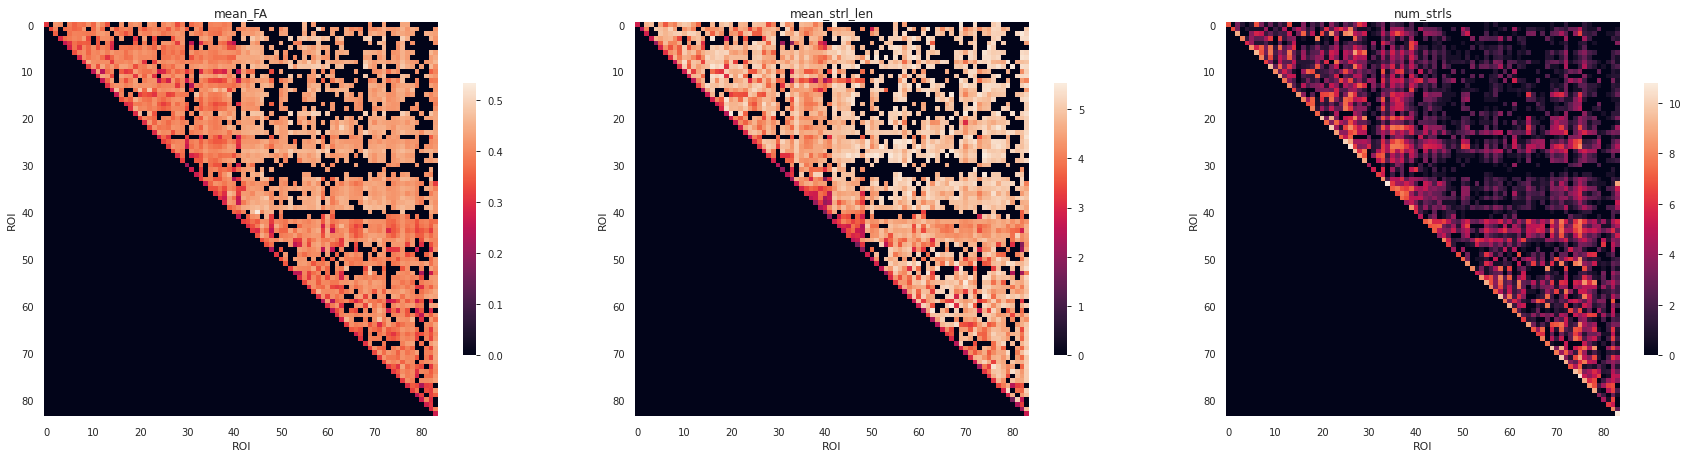

In [3]:
fig, ax = plt.subplots(1,3, figsize=(30,50))
for feature, i in zip(['mean_FA', 'mean_strl_len','num_strls' ], range(len(ax))):
    pcm = ax[i].imshow(np.log1p(feature_matrix('128127', feature)), interpolation = 'nearest')
    ax[i].set_xlabel('ROI')
    ax[i].set_ylabel('ROI')
    ax[i].set_title(feature)
    fig.colorbar(pcm, ax=ax[i], shrink=0.1)

Obtaining the training and test data for HCP subjects
    - Stacked features
        - column wise, each colum representing one feature
        - mean FA, mean streamline length, number of streamlines

In [4]:
tri = len(np.triu_indices(84)[0])

In [5]:
y_train = training_subjects() 
X_train = generate_training_data(tri, list(y_train.index))
y_test = test_subjects()
X_test = generate_test_data(tri, y_test.index)

In [6]:
X_train.head() # mean_FA x 3570 , mean_strl x 3570, num_strls x 3570

,0,1,2,3,4,5,6,7,8,9,...,10700,10701,10702,10703,10704,10705,10706,10707,10708,10709
128127,0.364943,0.0,0.519417,0.503094,0.0,0.474545,0.433842,0.462919,0.452018,0.501237,...,82.0,1.0,656.0,0.0,485.0,205.0,0.0,3186.0,12.0,47285.0
129028,0.369816,0.0,0.508501,0.490797,0.0,0.459788,0.430129,0.470305,0.498155,0.490954,...,242.0,0.0,575.0,0.0,294.0,151.0,0.0,5213.0,18.0,44125.0
129331,0.345616,0.0,0.504661,0.527672,0.0,0.521699,0.425600,0.525430,0.548743,0.536451,...,351.0,0.0,633.0,0.0,499.0,449.0,0.0,4787.0,26.0,62786.0
129937,0.393633,0.0,0.532236,0.517870,0.0,0.509366,0.451060,0.507100,0.549871,0.526258,...,558.0,0.0,673.0,0.0,313.0,279.0,0.0,4440.0,4.0,63220.0
130013,0.377380,0.0,0.558881,0.531706,0.0,0.541354,0.443790,0.499468,0.534220,0.523705,...,337.0,0.0,510.0,0.0,339.0,75.0,0.0,4026.0,6.0,42755.0


In [7]:
y_train.head()

,Subject,Release,Acquisition,Gender,Age,3T_Full_MR_Compl,T1_Count,T2_Count,3T_RS-fMRI_Count,3T_RS-fMRI_PctCompl,...,NEORAW_60,Noise_Comp,Odor_Unadj,Odor_AgeAdj,PainInterf_Tscore,Taste_Unadj,Taste_AgeAdj,Mars_Log_Score,Mars_Errs,Mars_Final
Subject,,,,,,,,,,,,,,,,,,,,,
128127,128127,S500,Q05,F,26-30,True,2,2,4,100.0,...,SA,2.0,101.12,86.45,51.1,89.68,88.45,1.84,2.0,1.76
129028,129028,Q2,Q03,M,26-30,True,2,2,4,100.0,...,SA,4.4,122.25,111.41,52.2,111.27,110.59,1.76,0.0,1.76
129331,129331,S900,Q9,F,26-30,True,2,2,4,100.0,...,A,4.4,122.25,111.41,38.6,99.67,98.45,1.80,2.0,1.72
129937,129937,S900,Q11,F,26-30,False,1,2,3,50.0,...,A,-99.0,108.79,98.04,38.6,97.69,96.97,1.80,0.0,1.80
130013,130013,Q1,Q01,M,26-30,True,2,2,4,100.0,...,SA,3.6,108.79,97.19,38.6,104.66,102.92,1.76,1.0,1.72


In [12]:
big5 = ['Agreeableness', 'Openness', 'Conscientiousness', 'Neuroticism',
            'Extraversion']
labels = ['NEOFAC_A', 'NEOFAC_O', 'NEOFAC_C', 'NEOFAC_N', 'NEOFAC_E']
mapping = {k: v for k, v in zip(big5, labels)}

Presenting one use case out of numerous possibilities in my pipeline

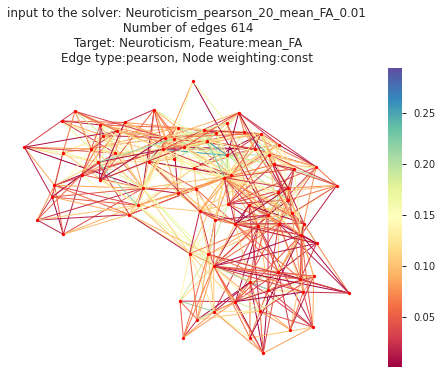

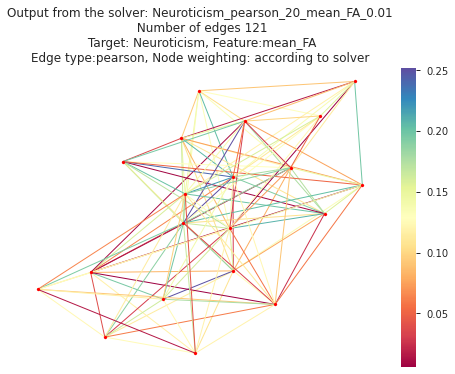

The number of nodes in the Input graph 84
The number of edges in the Input graph 614
The number of nodes in the output graph 20
The number of edges in the output graph 121


In [17]:

target = 'Neuroticism' # the personality trait to be classified
edge = 'pearson' # the coefficient we will use as an edge weight
feature ='mean_FA'# original feature derived from the connectivity matrix
node_wts = 'const' # type of node weights of the input graphs
val = -0.01 # the constant value given to the node weights
thresh = 0.01 # threshold for number of streamlines in the connection
max_num_nodes = 20 # number of nodes to preserve in the output graph
choice = 'test throw median'
feature_selection = 'solver'
classifier = 'SVC'
refit_metric = 'balanced_accuracy'
metrics = ['balanced_accuracy', 'accuracy', 'f1_weighted', 'roc_auc_ovr_weighted']
plotting_options = graph_options(color='red', node_size=10,line_color='white', linewidhts=0.1, width=1)

# Since we want to filter the edges in the input graph based on number of streamlines
strls_num = X_train.iloc[:, tri:2 * tri]
strls_num_l = strls_num.loc[X_train_l.index, :]
strls_num_l = strls_num.mean(axis=0, skipna=True)

X_train_l, X_test_l, y_train_l, y_test_l = process_data()
X_train_l, X_test_l, edge_wts, arr, input_graph, output_graph = solver_viz(X_train_l, 
                                                                           X_test_l, y_train_l, strls_num_l)

if len(edge_wts) != 0:
    train_res, test_res = cross_validation(classifier, X_train_l, y_train_l, X_test_l, y_test_l,
                                           metrics, refit_metric)

# Which brain network did the Graph Solver determine to make predictions about the  personality trait?

In [14]:
for node in output_graph.nodes:
    print(output_graph.nodes[node]['label'])

ctx-lh-caudalmiddlefrontal
ctx-lh-lateralorbitofrontal
ctx-lh-medialorbitofrontal
ctx-lh-parsopercularis
ctx-lh-parsorbitalis
ctx-lh-parstriangularis
ctx-lh-precentral
ctx-lh-rostralanteriorcingulate
ctx-lh-rostralmiddlefrontal
ctx-lh-superiorfrontal
ctx-lh-frontalpole
ctx-lh-insula
Left-Thalamus-Proper
Left-Caudate
Left-Putamen
Left-Pallidum
ctx-rh-medialorbitofrontal
ctx-rh-rostralanteriorcingulate
ctx-rh-superiorfrontal
ctx-rh-frontalpole


In [15]:
train_res

{'balanced_accuracy': 0.6990740740740741,
 'accuracy': 0.7033898305084746,
 'f1_weighted': 0.6666666666666666,
 'roc_auc_ovr_weighted': 0.6993634259259259}

In [16]:
test_res

{'balanced_accuracy': 0.4941471571906354,
 'accuracy': 0.4897959183673469,
 'f1_weighted': 0.4680851063829788,
 'roc_auc_ovr_weighted': 0.5451505016722408}